In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
import os
import math

2024-05-19 20:44:22.225605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 20:44:22.225730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 20:44:22.396564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [3]:
BASE_DIR = Path('/kaggle/input/captchafull/captcha_all_full')
TEST_DIR = Path('/kaggle/input/captchatestfull/captcha_test')

IMAGES = sorted(list(map(str, list(BASE_DIR.glob('*.png')))))
LABELS = [img.split(os.path.sep)[-1].split('.png')[0] for img in IMAGES]
TEST_IMAGES = sorted(list(map(str, list(TEST_DIR.glob('*.png')))))
TEST_LABELS = [img.split(os.path.sep)[-1].split('.png')[0] for img in TEST_IMAGES]
CHARACTERS = set(char for LABEL in LABELS for char in LABEL)

print(f'Number of Images found: {len(IMAGES)}')
print(f'Number of Labels found: {len(LABELS)}')
print(f'Number of Unique Characters found: {len(CHARACTERS)}')
print(f'Character List: {CHARACTERS}')

Number of Images found: 99882
Number of Labels found: 99882
Number of Unique Characters found: 62
Character List: {'Y', 'x', '8', 'i', 'C', '5', 'n', 'B', 'P', 'j', '7', 'X', 'g', '1', 'U', 'u', 'z', '4', 'a', 'r', '0', 'm', 'K', 'Q', 'k', 'd', 'T', 'N', 's', 'W', 'b', 'c', 'E', 'G', 'A', 'R', 'H', 'w', '3', 'M', 'f', 'y', 'L', 'Z', 'v', 'D', 'p', 'V', 'I', 't', 'o', 'e', 'J', '9', 'q', '6', 'F', 'S', 'l', 'h', '2', 'O'}


In [4]:
IMAGES[0], LABELS[0]

('/kaggle/input/captchafull/captcha_all_full/003A6.png', '003A6')

In [5]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

IMG_WIDTH, IMG_HEIGHT = 150, 40
downsample_factor = 4
max_length = max([len(label) for label in LABELS])
MAX_CHARS = len(CHARACTERS)
max_length

5

## Data Pre-Processing

In [6]:
char_to_num = layers.StringLookup(vocabulary=list(CHARACTERS),
                                  num_oov_indices=0,
                                  mask_token=None)

num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), 
                                  mask_token=None, 
                                  num_oov_indices=0,
                                  invert=True)

In [7]:
def split_data(images, labels, train_size=0.8, shuffle=True):
    size = len(images)
    
    indices = np.arange(size)
    
    if shuffle:
        np.random.shuffle(indices)
        
    train_samples = int(size * train_size)
    
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid

In [8]:
def encode_single_sample(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.one_hot(indices=label, depth=MAX_CHARS+1)
    return img, label

In [9]:
X_train, X_valid, y_train, y_valid = split_data(np.array(IMAGES), np.array(LABELS))

In [10]:
X_train[0], y_train[0], tf.strings.reduce_join(num_to_char(char_to_num(tf.strings.unicode_split(y_train[0], input_encoding="UTF-8")))).numpy().decode('utf-8')

('/kaggle/input/captchafull/captcha_all_full/bcNyd.png', 'bcNyd', 'bcNyd')

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, 
                      num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = (
    valid_dataset.map(encode_single_sample, 
                      num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((TEST_IMAGES, TEST_LABELS))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

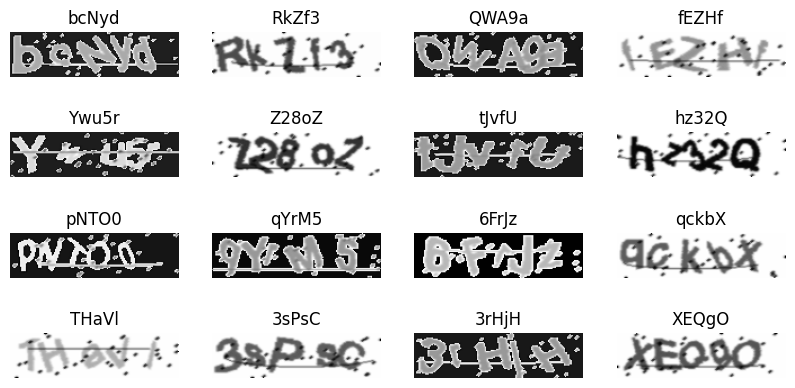

In [12]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
        
#    images = batch['image']
#    labels = batch['label']
    images = batch[0]
    labels = batch[1]
    # print(batch[1].shape)
    # print('Single Label Shape', labels[0].shape,' Label Value is: ', labels[0])
    for i in range(16):
        img = (images[i]*255).numpy().astype('uint8')
        ori_label = []
        
        for l in labels[i]:
            ori_label.append(np.argmax(l))
        
        label = tf.strings.reduce_join(num_to_char(ori_label)).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

## Model

In [14]:
class SqueezeLayer(layers.Layer):
    def __init__(self, name='squeeze_layer'):
        super().__init__(name=name)
        pass
        
    def call(self, inp):
        return tf.squeeze(inp, axis=2)

In [15]:
initial_learning_rate = 0.001

In [16]:
def get_model_2():
    tf.random.set_seed(108)
    img_inp = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name='image')
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', name='conv_1')(img_inp)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(x)
    
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name="conv_3_bn")(x)
    x = layers.ReLU(name="conv_3_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_3')(x)
    
    x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name="conv_4_bn")(x)
    x = layers.ReLU(name="conv_4_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_4')(x)
    
    x = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name="conv_5_bn")(x)
    x = layers.ReLU(name="conv_5_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='pool_5')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(1024, name='dense_1')(x)
    x = layers.BatchNormalization(name="dense_1_bn")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(max_length * (len(CHARACTERS) + 1), name='dense_2')(x)
    x = layers.Reshape((max_length, len(CHARACTERS) + 1))(x)
    out = layers.Activation('softmax', name='softmax')(x)
    
    model = tf.keras.Model(img_inp, out, name="OCR_Model")
    opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [17]:
EPOCHS = 100
PATIENCE = 10

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

lrate = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

model = get_model_2()
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, lrate]
)

Model: "OCR_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 150, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 150, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, 150, 40, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (ReLU)              │ (None, 150, 40, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 75, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 75, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_bn (BatchNormalization)  │ (None, 75, 20, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_relu (ReLU)              │ (None, 75, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 37, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 37, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_bn (BatchNormalization)  │ (None, 37, 10, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_relu (ReLU)              │ (None, 37, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 18, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 18, 5, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_bn (BatchNormalization)  │ (None, 18, 5, 256)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_relu (ReLU)              │ (None, 18, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 9, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 9, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5_bn (BatchNormalization)  │ (None, 9, 2, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5_relu (ReLU)              │ (None, 9, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_5 (MaxPooling2D)           │ (None, 4, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_bn (BatchNormalization) │ (None, 1024)           │         4,096 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,424,251 (9.25 MB)

 Trainable params: 2,420,219 (9.23 MB)

 Non-trainable params: 4,032 (15.75 KB)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
   7/2498 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.0128 - loss: 4.8822 

I0000 00:00:1716151581.155608     137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716151581.181143     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2498/2498 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1142 - loss: 3.7537

W0000 00:00:1716151666.507555     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2498/2498 ━━━━━━━━━━━━━━━━━━━━ 121s 43ms/step - accuracy: 0.1143 - loss: 3.7533 - val_accuracy: 0.2162 - val_loss: 4.3608 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.6564 - loss: 1.1640 - val_accuracy: 0.3784 - val_loss: 3.1634 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7999 - loss: 0.6526 - val_accuracy: 0.4900 - val_loss: 2.7174 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.8566 - loss: 0.4567 - val_accuracy: 0.6109 - val_loss: 1.5867 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - accuracy: 0.8867 - loss: 0.3519 - val_accuracy: 0.6782 - val_loss: 1

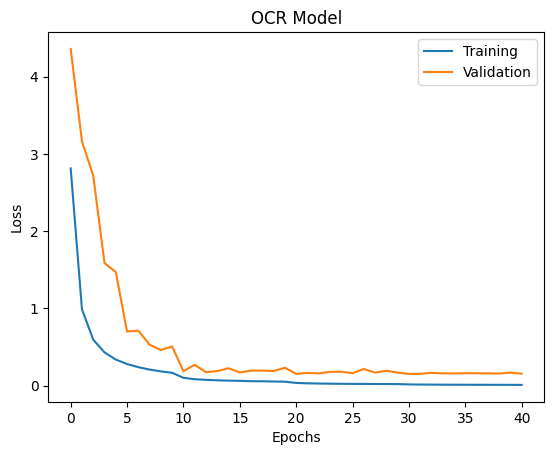

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('OCR Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

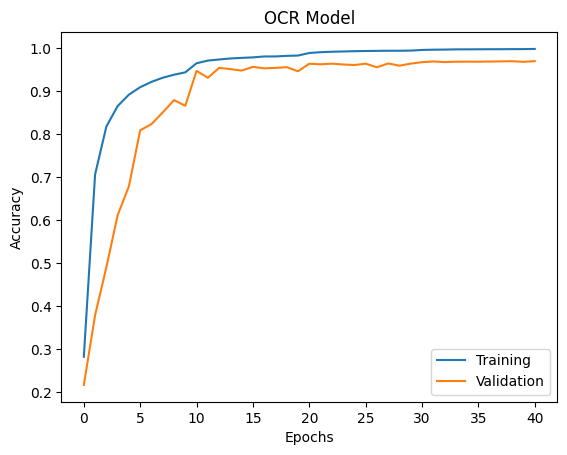

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('OCR Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [20]:
val_loss, val_acc = model.evaluate(valid_dataset, verbose=0)
print(f'Validation Accuracy: {val_acc*100:.3f}%')

Validation Accuracy: 96.670%


In [21]:
def plot_predict_captcha(dataset):
    _, ax = plt.subplots(8, 4, figsize=(20, 15))
    for batch in valid_dataset.take(1):
        images, labels = batch
        preds = model.predict(images)

        for i in range(8):
            for j in range(4):
                index = i*4 + j

                img = (images[index]*255).numpy().astype('uint8')

                ori_label = tf.argmax(labels[index], axis=1)
                pred_label = tf.argmax(preds[index], axis=1)

                true_label = tf.strings.reduce_join(num_to_char(ori_label)).numpy().decode('utf-8')
                pred_label = tf.strings.reduce_join(num_to_char(pred_label)).numpy().decode('utf-8')

                title_color = 'green' if true_label == pred_label else 'red'

                ax[i, j].imshow(img[:, :, 0].T, cmap='gray')
                ax[i, j].set_title(f'True: {true_label}\nPred: {pred_label}', color=title_color)
                ax[i, j].axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


W0000 00:00:1716153431.857742     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


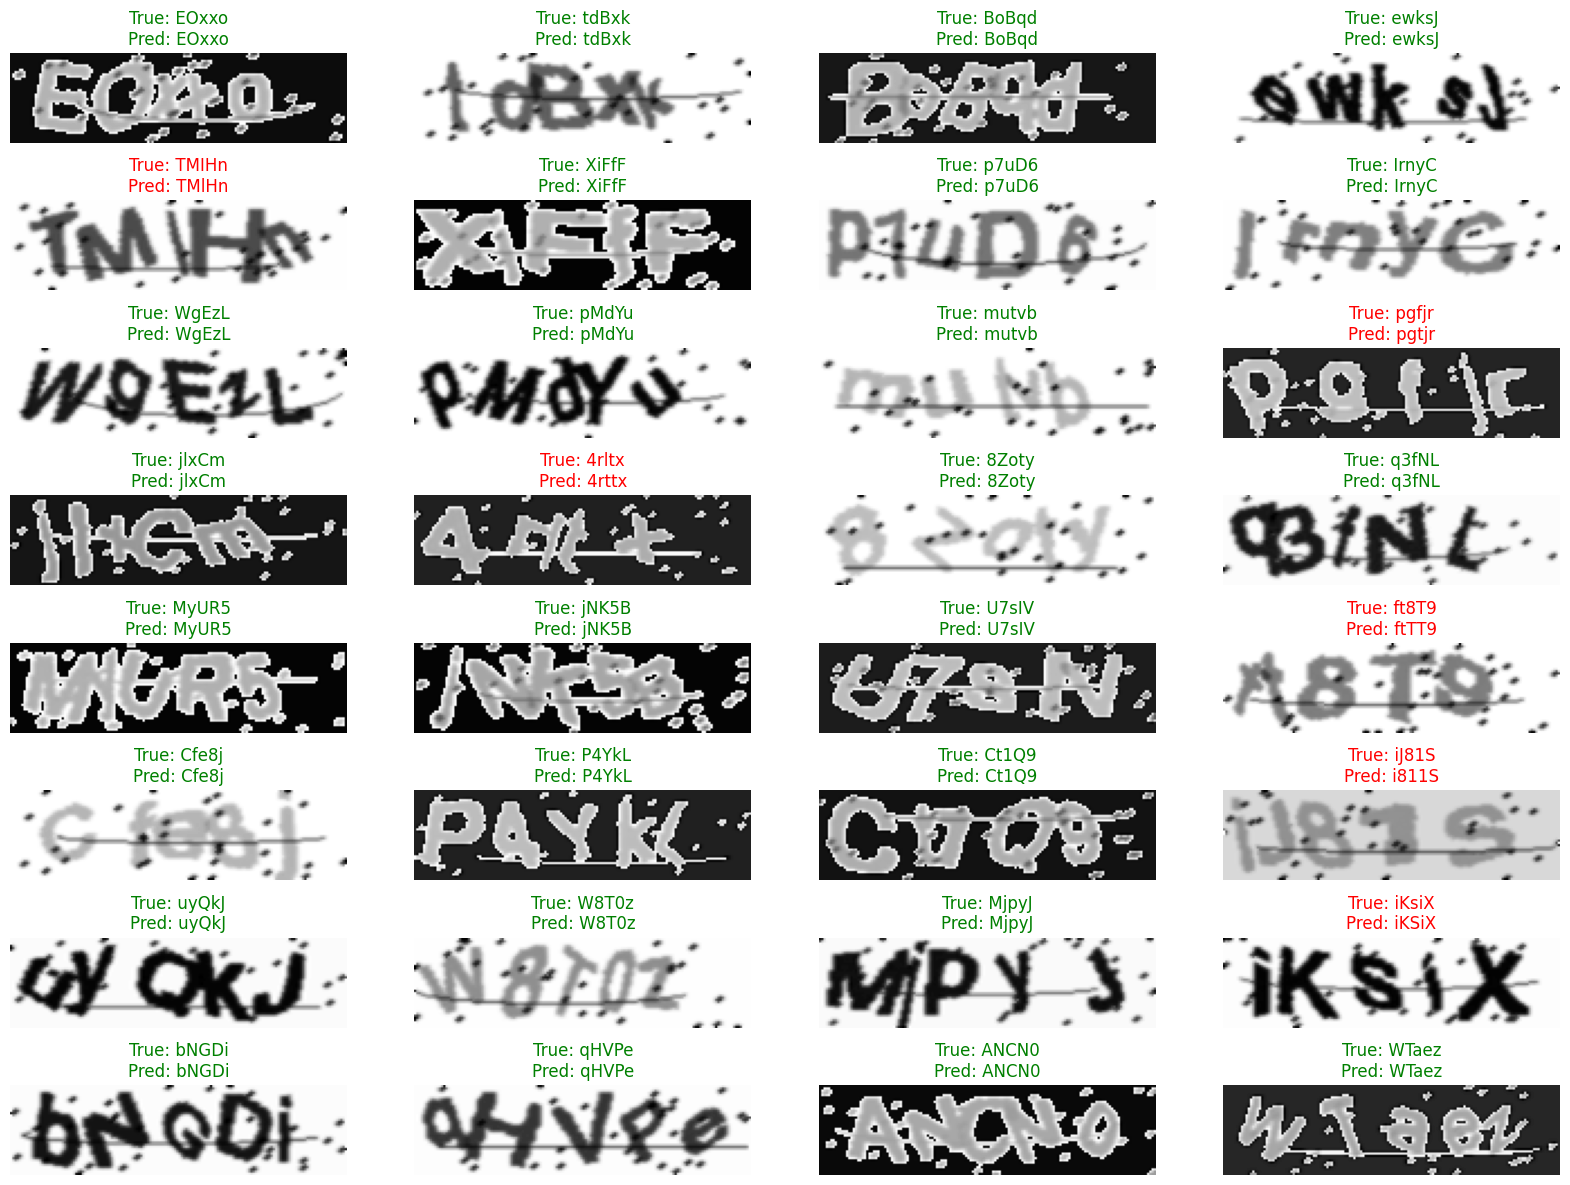

In [22]:
plot_predict_captcha(valid_dataset)

In [23]:
model.save('ocr_letter_number_model_v4.h5')

In [24]:
val_loss, val_acc = model.evaluate(test_dataset, verbose=0)
print(f'Test Accuracy: {val_acc*100:.3f}%')

Test Accuracy: 96.800%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


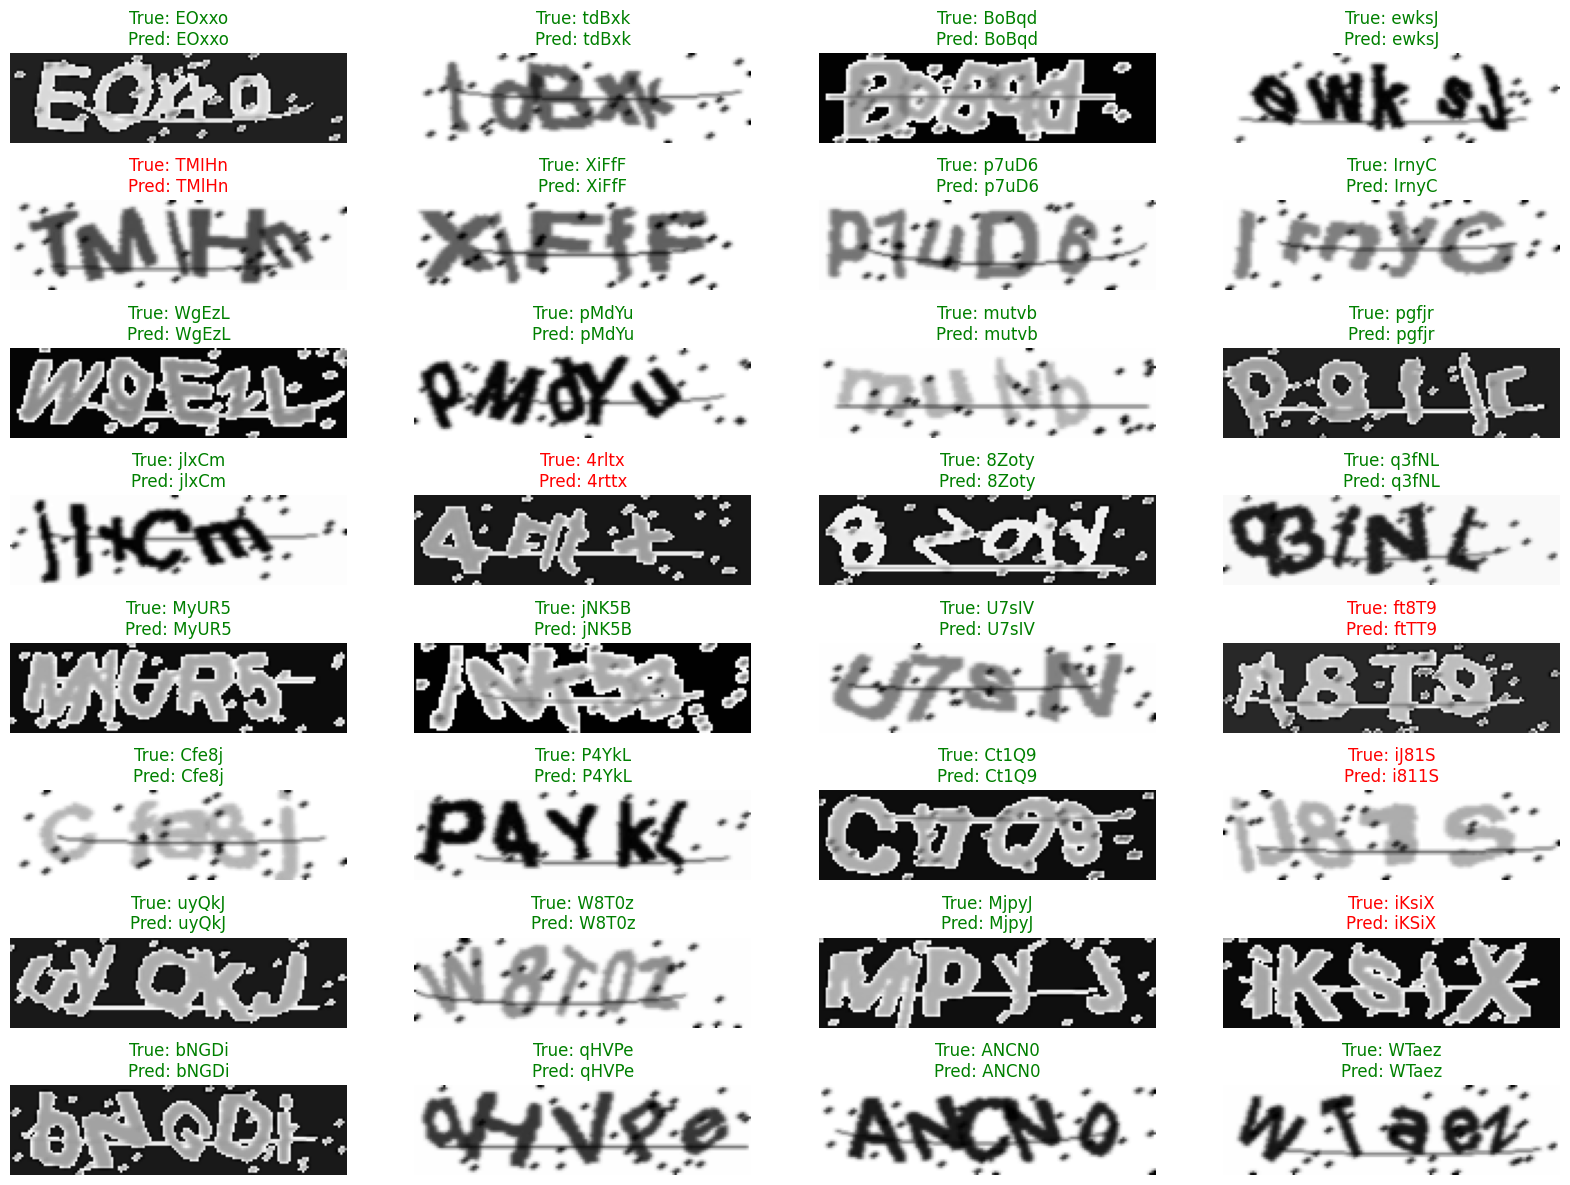

In [25]:
plot_predict_captcha(test_dataset)